In [14]:
%matplotlib inline

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


Automatically created module for IPython interactive environment


GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -179.191

Learned kernel: 0.00316**2 * RBF(length_scale=1e+05) + 0.00316**2 * RBF(length_scale=1e+05) * ExpSineSquared(length_scale=0.335, periodicity=0.0545) + 0.97**2 * RationalQuadratic(alpha=390, length_scale=0.163) + 0.00316**2 * RBF(length_scale=0.0287) + WhiteKernel(noise_level=0.117)
Log-marginal-likelihood: -127.669


C:\Users\eveba\.conda\envs\Machine_Learning\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\eveba\.conda\envs\Machine_Learning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\eveba\.conda\envs\Machine_Learning\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasin

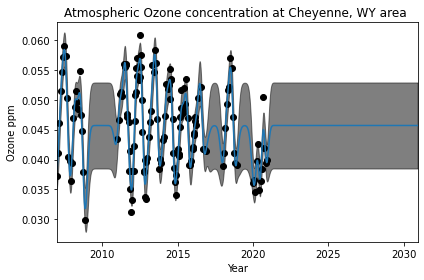

In [16]:
def Ozone_prep():
    #read the csv file into dataframe
    #dataset = pd.read_csv("GPR/RaleighLearnNO2GPR.csv")
    dataset = pd.read_csv("GPR/KgMerges/WY/WyomingOzoneKg.csv")
    #dataset.head()
    #target
    y = dataset.iloc[:,0]

    #dataset
    X = dataset.iloc[:,1:6]
    X.columns
    #X.drop(['Site Name'],axis=1)

    months = []
    ppmv_sums = []
    counts = []
    
    m = X['Month']
    year = X['Year']
    month_float = year + (m - 1) / 12
    ppmvs = dataset.iloc[:,0]

    for month, ppmv in zip(month_float, ppmvs):
            if not months or month != months[-1]:
                months.append(month)
                ppmv_sums.append(ppmv)
                counts.append(1)
            else:
                # aggregate monthly sum to produce average
                ppmv_sums[-1] += ppmv
                counts[-1] += 1
            
    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs
 
newX, newy = Ozone_prep()   

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms


kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(newX, newy)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 34.4**2 * RBF(length_scale=41.8)  # long term smooth rising trend
k2 = 3.27**2 * RBF(length_scale=180.0) \
    * ExpSineSquared(length_scale=1.88, periodicity=1.0)
                     
k3 = 0.446**2 * RationalQuadratic(length_scale=0.957, alpha=17.7)
k4 = 0.197**2 * RBF(length_scale=0.138) \
    + WhiteKernel(noise_level=0.0336)
                 
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(newX, newy)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(newX.min(), newX.max() + 10, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(newX, newy, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"Ozone ppm")
plt.title(r"Atmospheric Ozone concentration at Cheyenne, WY area ")
plt.tight_layout()
plt.show()

In [ ]:
# model does not converge but the Log-marginal-likelihood: -192.878
# the noise level was reduced but the convergence flag was still triggered